<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard1/golds_ocupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import numpy as np

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(ook(y_true), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
        print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami




# Subclassing for GS

In [16]:
 # -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=4):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):

        def scheduler1(step = 10, ratio = 1.2):
          def scheduler(epoch, lr):
            if epoch % step == 0 and epoch>1:
              return lr/ratio
            else:
              return lr
          return scheduler
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        initializer = tf.keras.initializers.GlorotNormal(seed=100)

        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*self.neurons*(self.K+self.R)),activation='selu',name='h1',bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output', bias_initializer='zeros', kernel_initializer=initializer,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
               
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q, 'neurons': self.neurons
                }

  
        return self


In [17]:
 #https://drive.google.com/file/d/1QQDt-NXoqbgRQShQ92WTSI84RY628tHy/view?usp=sharing

 #cargar datos desde drive acceso libre
FILEID = "1QQDt-NXoqbgRQShQ92WTSI84RY628tHy"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O file.zip && rm -rf /tmp/cookies.txt
!unzip -o file.zip
!dir

--2023-02-13 21:11:31--  https://docs.google.com/uc?export=download&confirm=&id=1QQDt-NXoqbgRQShQ92WTSI84RY628tHy
Resolving docs.google.com (docs.google.com)... 142.250.153.138, 142.250.153.101, 142.250.153.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.153.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sl7d333rgjclh5l5904j6t0r4pj5iesq/1676322675000/07591141114418430227/*/1QQDt-NXoqbgRQShQ92WTSI84RY628tHy?e=download&uuid=f769eb8c-d79a-4144-be15-74541916eeba [following]
--2023-02-13 21:11:31--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sl7d333rgjclh5l5904j6t0r4pj5iesq/1676322675000/07591141114418430227/*/1QQDt-NXoqbgRQShQ92WTSI84RY628tHy?e=download&uuid=f769eb8c-d79a-4144-be15-74541916eeba
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 108.177.119.1

# Load Data

In [18]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Ocupancy' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']

 

In [19]:
dfo= pd.read_csv("/content/file.csv")
dfo

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.700000,26.272000,585.200000,749.200000,0.004764,1
1,23.718000,26.290000,578.400000,760.400000,0.004773,1
2,23.730000,26.230000,572.666667,769.666667,0.004765,1
3,23.722500,26.125000,493.750000,774.750000,0.004744,1
4,23.754000,26.200000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...
2660,24.290000,25.700000,808.000000,1150.250000,0.004829,1
2661,24.330000,25.736000,809.800000,1129.200000,0.004848,1
2662,24.330000,25.700000,817.000000,1125.800000,0.004841,1
2663,24.356667,25.700000,813.000000,1123.000000,0.004849,1


In [20]:
dfo['Occupancy'].value_counts()

0    1693
1     972
Name: Occupancy, dtype: int64

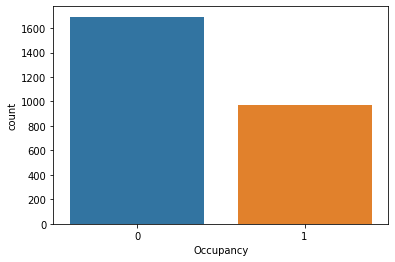

In [21]:
#Histogram showing distribution of 'OCCUPANCY'
import seaborn as sns
sns.countplot(data = dfo , x = 'Occupancy')
plt.show()

In [22]:
#Removing the HumidityRatio attribute which is least correlated to the target attribute 
t=dfo['Occupancy'].values
X = dfo.drop(['HumidityRatio','Occupancy'], axis = 1).values

In [23]:
if len(np.unique(t))== 2:
    t=t+1

# Labels Generation  

In [24]:
t = t - 1

# Split data

In [25]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3, random_state=123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test = X[train_index,:], X[test_index,:]  #, Ytr_mv[train_index,:], Ytr_mv[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape,  Y_true_train.shape)

[ 315  235 1480 1538 1087 1009 1677 1094  343 2175 1455 2535 2641  798
  417 2238 1781 1445   85 1828 2029 1034 1067 1458 2455  732 2434 2247
 2113 2386  689  853 2200 2500  179 1245 1758 1927  709 1826 2529 1099
  805  601 1022 1730 2135 1361 2294 2644  206  420  878 2093 1400 1518
  934 1622 1279  613  957  190   33 1450  335 1371 2634  103  304 1228
 2242 2384 1637  673  222 2340 1765  360  289   25   45 1937  537 1237
 1183 2095 2375 2379 2390 2170 2607  589 1833 2628  354  189 2016 1286
 1116  556 1918  937 1740  803 2435  257  807 1697 2494 2538  249  683
 1673 1391  871 1064 1364  814  184  498 1898 1017 1055  906  645  242
  684  779  784 1696 1226  423  966 2596  649 1008 2402  101 1283 1529
 2417 1449  616 1107 1845 1011 1572 2525 2380 2651  704 1089  466 1853
 2462 1726 2502 2479 1710 1050  469  220  336  263 1535  554 2590 1273
 2543  861  449 1224 1957 2537 1106  114 1213 2194  830  973 1504 2168
  777 1975  996 2025 2094  707  994 2315 1970  748 1982 2430 1511   43
 2291 

# Apply MinMaxScaler

In [26]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


In [27]:
# from sklearn.metrics import classification_report, balanced_accuracy_score
# from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
# l1 =  0.0001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# MI = np.zeros(NUM_RUNS)
# NMI = np.zeros(NUM_RUNS)
# AMI = np.zeros(NUM_RUNS)
# BACC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_PRI(epochs=100,batch_size=256,R=5, K=2, dropout=0.5, learning_rate=0.01,optimizer='Adam', 
#                     l1_param=l1,  validation_split=0.3, verbose=0)
    
#     MA.fit(X_train,  Y_true_train)
#     MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     print("Validation ACC: %.4f" % (float(ACC[i])))


#     # balanced. Accurcy
#     BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
#     print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

#     #MI
    
#     MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation MI: %.4f" % (float(MI[i]),))
#     NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
#     AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    

iteration: 0


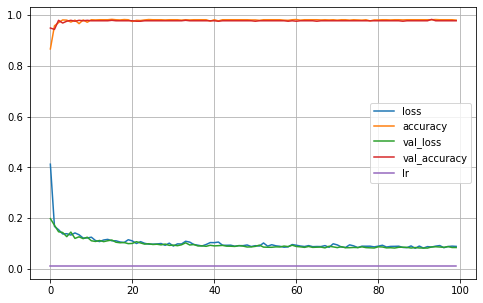

25/25 [==============================] - 0s 2ms/step
iteration: 1


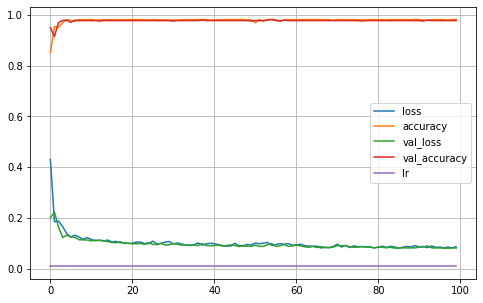

25/25 [==============================] - 0s 2ms/step
iteration: 2


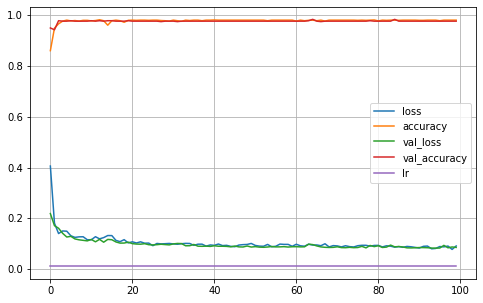

25/25 [==============================] - 0s 1ms/step
iteration: 3


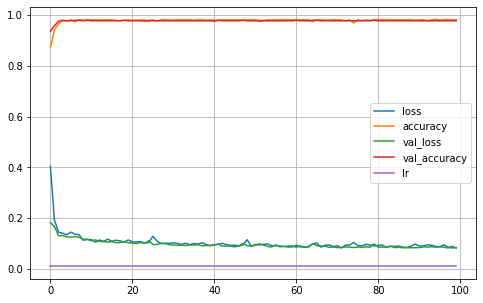

25/25 [==============================] - 0s 2ms/step
iteration: 4


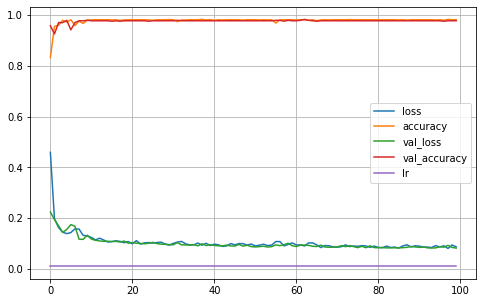

25/25 [==============================] - 0s 2ms/step
iteration: 5


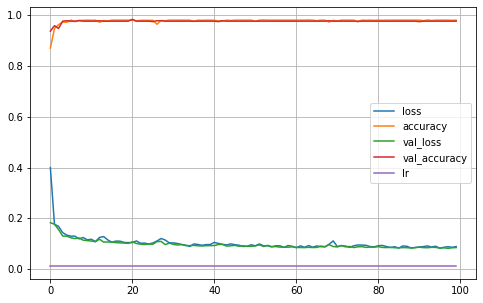

25/25 [==============================] - 0s 2ms/step
iteration: 6


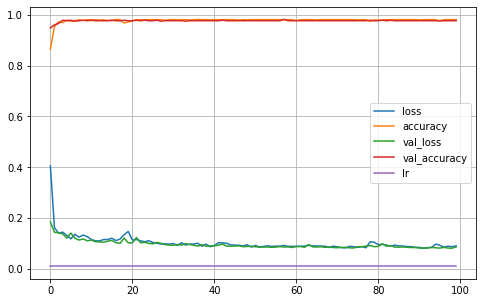

25/25 [==============================] - 0s 2ms/step
iteration: 7


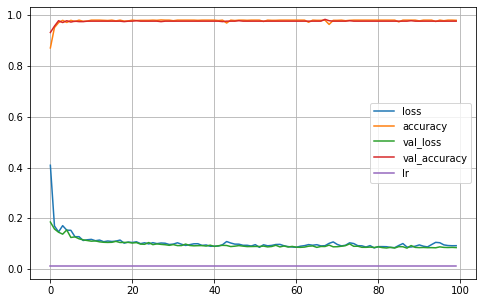

25/25 [==============================] - 0s 2ms/step
iteration: 8


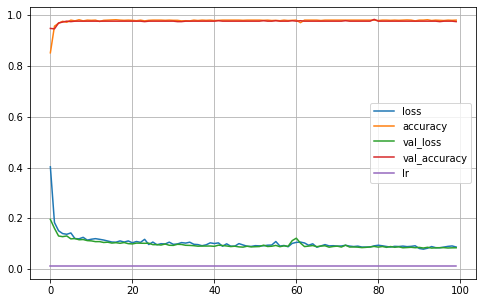

25/25 [==============================] - 0s 2ms/step
iteration: 9


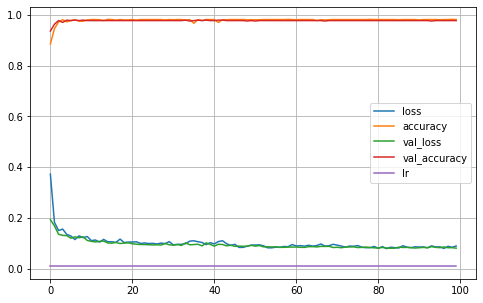

25/25 [==============================] - 0s 2ms/step


In [28]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import pandas as pd
l1 =  0.0001
NUM_RUNS =10
custom_loss = "GOLD"


results = []
for i in range(NUM_RUNS):

    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=256,R=5, K=2, dropout=0.5, learning_rate=0.01,optimizer='Adam', 
                    l1_param=l1,  validation_split=0.3, verbose=0)
    


    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  
    # Generate the predictions for the current run
    pred_2 = MA.predict(X_test)
     
    acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(Y_true_test,  pred_2, print_result=False)  # mi, ami,
    
    # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': acc,
        'balanced_accuracy': bacc,
       # 'mutual_information': mi,
        'normalized_mutual_information': nmi,
     #   'adjusted_mutual_information': ami,
        'auc_tensorflow': auc,
        'auc_scikit_learn': auc_sk,
    })
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  


In [29]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,97.50,95.84,83.58,97.919998,99.38
1,97.62,96.03,84.16,98.019997,99.41
2,97.62,96.03,84.16,98.019997,99.40
3,97.62,96.03,84.16,98.019997,99.40
4,97.62,96.03,84.16,98.019997,99.41
5,97.62,96.03,84.16,98.019997,99.40
6,97.50,95.84,83.58,97.919998,99.40
7,97.62,96.03,84.16,98.019997,99.39
8,97.62,96.03,84.16,98.019997,99.40
9,97.62,96.03,84.16,98.019997,99.41


In [30]:
mean

accuracy                         97.60
balanced_accuracy                95.99
normalized_mutual_information    84.04
auc_tensorflow                   98.00
auc_scikit_learn                 99.40
dtype: float64

In [31]:
std

accuracy                         0.05
balanced_accuracy                0.08
normalized_mutual_information    0.24
auc_tensorflow                   0.04
auc_scikit_learn                 0.01
dtype: float64

In [32]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

In [33]:
result_df

,Mean,Std
accuracy,97.60,0.05
balanced_accuracy,95.99,0.08
normalized_mutual_information,84.04,0.24
auc_tensorflow,98.00,0.04
auc_scikit_learn,99.40,0.01


In [34]:
# Save the DataFrame to an excel file
result_df.to_excel(database + custom_loss + ".xlsx")